In [1]:
# 초기 1회 실행
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# 📥 데이터 다운로드 (Download Dataset)
# GitHub에서 csv 파일을 다운로드합니다.

!wget https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_train1.csv
!wget https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_test1.csv

--2025-06-27 13:13:32--  https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_train1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5286258 (5.0M) [text/plain]
Saving to: ‘secom_nona_train1.csv’

secom_nona_train1.c 100%[===================>]   5.04M  --.-KB/s    in 0.05s   

2025-06-27 13:13:33 (112 MB/s) - ‘secom_nona_train1.csv’ saved [5286258/5286258]

--2025-06-27 13:13:33--  https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/secom_nona_test1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

# SECOM 반도체 제조 데이터셋을 기반으로 제품 불량 여부 예측하는 이진 분류 모델 개발


In [3]:
## 필요 패키지 설치 및 import
import importlib.util
import subprocess
import sys
def install_and_import(packages):
    for pkg in packages:
        package = pkg
        try:
            importlib.util.find_spec(package)
            print(f"{package} is already installed.")
        except ImportError:
            # 모듈이 설치되어 있지 않은 경우 설치시도
            print(f"{package} is not installed. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            subprocess.check_call(["conda", "install", package, "-y"])

            # 설치 후 다시 임포트를 시도
            importlib.import_module(package)
            print(f"{package} has been successfully installed.")

        # finally:
        #     globals()[package] = importlib.import_module(package)
        except Exception as e:
            # 설치 중 예외가 발생한 경우, 에러 메시지를 출력
            print(f"An error occurred while installing {package}: {str(e)}")

# 예시 사용법
install_and_import(['xgboost', 'pycaret'])


xgboost is already installed.
pycaret is already installed.


In [4]:
## 필요 모듈 임포트
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# SECOM DATASET


# 데이터 읽기

## 데이터 입력

In [6]:
train = pd.read_csv('secom_nona_train1.csv')
test = pd.read_csv('secom_nona_test1.csv')

In [7]:
train

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_582,x_583,x_584,x_585,x_586,x_587,x_588,x_589,target,datetime
0,3068.67,2517.04,2258.2778,2073.0764,1.2329,100.0,96.9478,0.1208,1.3524,0.0020,...,0.5024,0.0210,0.0045,4.1720,0.0276,0.0160,0.0053,57.7824,0,25/09/2008 10:23:00
1,2995.73,2515.83,2231.6111,2005.8966,1.2969,100.0,93.7522,0.1234,1.4136,0.0129,...,0.5011,0.0103,0.0027,2.0617,0.0090,0.0166,0.0047,183.3928,0,24/09/2008 10:10:00
2,2953.63,2384.04,2191.2111,1437.5003,2.2073,100.0,97.6444,0.1235,1.3584,-0.0024,...,0.4968,0.0188,0.0041,3.7853,0.0137,0.0326,0.0108,237.4625,0,03/10/2008 00:24:00
3,3043.70,2535.71,2127.9555,1011.1924,1.0863,100.0,107.1522,0.1261,1.4221,-0.0098,...,0.4948,0.0124,0.0030,2.5147,0.0215,0.0071,0.0027,33.1090,0,11/09/2008 21:13:00
4,2971.93,2557.58,2189.8778,1158.0925,1.5291,100.0,107.8200,0.1219,1.5361,0.0188,...,0.4965,0.0217,0.0047,4.3766,0.0419,0.0098,0.0032,23.3852,0,07/09/2008 23:33:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,2929.93,2517.50,2218.8778,1188.2630,1.2557,100.0,100.9444,0.1212,1.5189,-0.0090,...,0.4999,0.0098,0.0029,1.9702,0.0429,0.0401,0.0150,93.5134,0,15/09/2008 19:54:00
1327,3142.21,2389.91,2223.5333,1352.1869,0.8714,100.0,97.2189,0.1196,1.3465,-0.0054,...,0.5037,0.0252,0.0056,4.9959,0.0091,0.0169,0.0047,185.8369,0,15/10/2008 06:49:00
1328,3110.23,2397.92,2184.8889,905.1501,1.3378,100.0,106.6900,0.1226,1.4349,0.0062,...,0.4934,0.0126,0.0030,2.5513,0.0274,0.0072,0.0019,26.1430,0,02/09/2008 12:01:00
1329,3047.19,2524.18,2197.3111,969.8910,1.3015,100.0,105.3911,0.1201,1.5837,-0.0266,...,0.4967,0.0113,0.0034,2.2808,0.0082,0.0162,0.0054,197.9951,0,27/07/2008 22:28:00


In [8]:
train['target'].value_counts()

,count
target,
0,1243
1,88


In [9]:
## 시간 포맷 변경
train['datetime'] = pd.to_datetime(train['datetime'], format = "%d/%m/%Y %H:%M:%S")
test['datetime'] = pd.to_datetime( test['datetime'], format = "%d/%m/%Y %H:%M:%S")

## 시간 정보 따로 저장
train_time = train['datetime']
test_time = test['datetime']

## train/test 분리
X_train = train.drop(['datetime',  'target'], axis=1)
y_train = train['target']

X_test = test.drop(['datetime', 'target'], axis=1)
y_test = test['target']

## 데이터 불균형 확인

In [10]:
y_train.value_counts()

,count
target,
0,1243
1,88


In [11]:
y_test.value_counts()

,count
target,
0,220
1,16


## 임의의 변수 그려보기

In [12]:
## 임시 df 생성
temp_df = train.copy()
temp_df.sort_values(by = 'datetime', inplace = True)
temp_df.reset_index(drop = True, inplace = True)

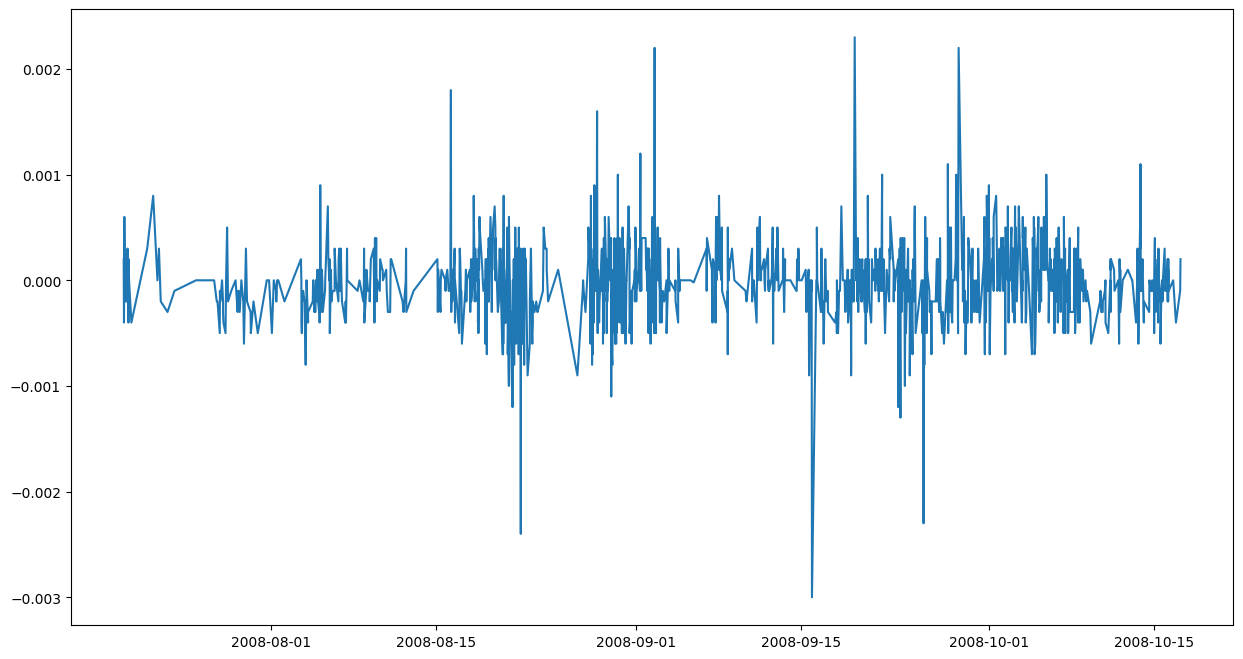

In [13]:
## 임의의 변수
plt.figure(figsize = (15, 8))
plt.plot(temp_df['datetime'], temp_df['x_100'])

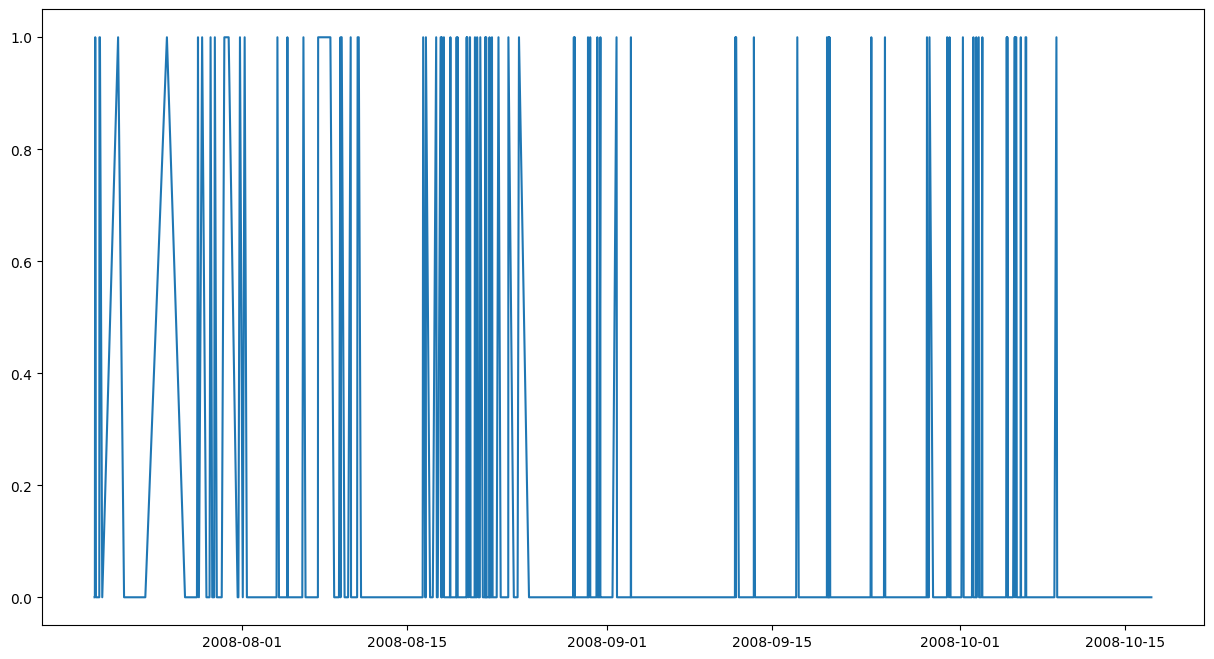

In [14]:
## 시간별 target
plt.figure(figsize = (15, 8))
plt.plot(temp_df['datetime'], temp_df['target'])

# 랜덤포레스트 사용

## 기본 모델

In [15]:
## 기본 랜덤포레스트 모델 학습
rf_model = RandomForestClassifier(random_state = 1)

rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=1)

In [16]:
y_pred_basic = rf_model.predict(X_test)
y_pred_basic

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## 하이퍼파라미터 최적화

In [17]:
## GridSearchCV 사용하여 하이퍼파라미터 최적화
## 많이 오래 걸림...
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 20}] # 비중의 반대로 가중치 줘야 함
}

rf_model2 = RandomForestClassifier(random_state = 123)

grid_search = GridSearchCV(estimator = rf_model2,
                                                          param_grid = param_grid,
                                                          cv = 3,
                                                          n_jobs = -1,
                                                          verbose = 2)

In [18]:
## 최적 모델 찾기
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          {0: 1, 1: 20}],
                         'max_depth': [3, 5, 10, None],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [19]:
## 최적화된 모델로 예측 및 평가
y_pred_best  =  grid_search.best_estimator_.predict(X_test)
y_pred_best # 큰 차이가 없음...ㅠㅠ

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## 최종모델의 변수 중요도

In [20]:
rf_final = grid_search.best_estimator_

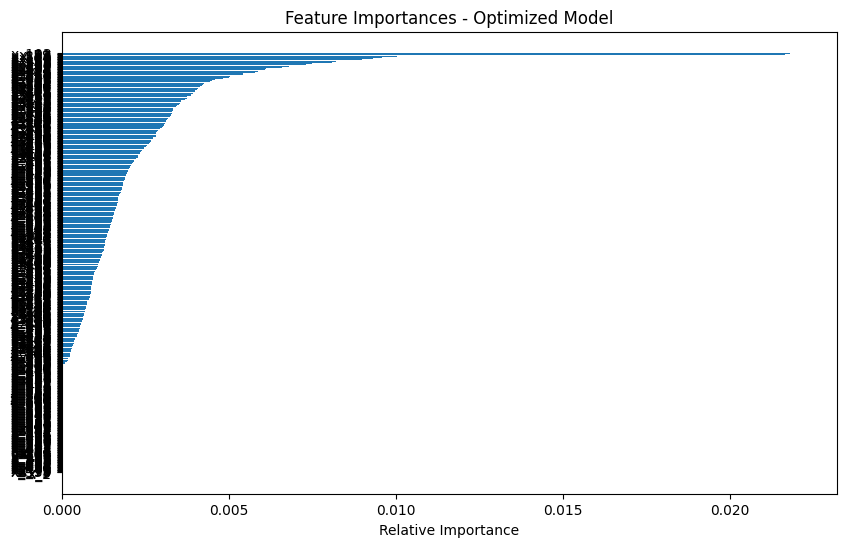

In [21]:
## 최종 모델의 변수 중요도(변수가 많아서 오래 걸림..)
importance = rf_final.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importance)

plt.figure(figsize = (10, 6))
plt.title('Feature Importances - Optimized Model')
plt.barh(range(len(indices)), importance[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 상위 k개만 뽑아보기

In [22]:

## 중요도가 높은 순으로 상위 10개의 feature 추출
indices_top10 = indices[::-1][:10]  # 상위 10개의 인덱스 추출

## 상위 10개의 변수명과 중요도를 DataFrame으로 저장
top_10_features = pd.DataFrame({
    'Feature': feature_names[indices_top10],
    'Importance': importance[indices_top10]
})

## 상위 10개 변수 중요도 출력
top_10_features

,Feature,Importance
0,x_103,0.022077
1,x_59,0.021790
2,x_33,0.021651
3,x_247,0.013310
4,x_510,0.013252
5,x_64,0.010042
6,x_126,0.009573
7,x_130,0.009570
8,x_152,0.009309
9,x_125,0.008977


## 혼동행렬 및 Classification report 출력

In [23]:
from sklearn.metrics import confusion_matrix

def custom_confusion_matrix(y_true, y_pred):

        ## 혼동 행렬 계산
        cm = confusion_matrix(y_true=y_true,
                                                          y_pred=y_pred)
        ## 클래스 1을 기준으로 행과 열 순서 변경
        cm = cm[::-1, ::-1]

        ## 행과 열을 바꾸기 위해 전치(transpose)
        cm_transposed = cm.T
        print(cm_transposed)


        # DataFrame으로 변환 (라벨 추가)
        df_cm = pd.DataFrame(cm_transposed,
                                                      index = ['pred 1', 'pred 0'],
                                                      columns = ['act 1', 'act 0'])

        ## 히트맵 그리기
        plt.figure(figsize = (7,5))
        sns.heatmap(df_cm, annot = True, fmt = 'd', cmap = 'Blues')
        plt.title('Confusion Matrix (Class 1 as Positive)')
        plt.ylabel('Predicted')
        plt.xlabel('Actual')
        plt.show()

기본 모델
[[  0   0]
 [ 16 220]]


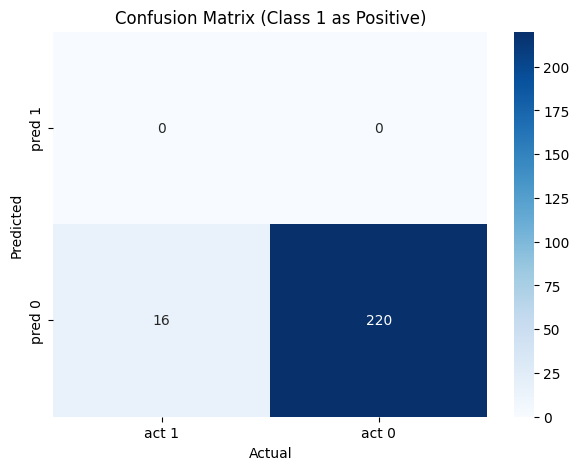

하이퍼파라미터 최적화 모델
[[  0   0]
 [ 16 220]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


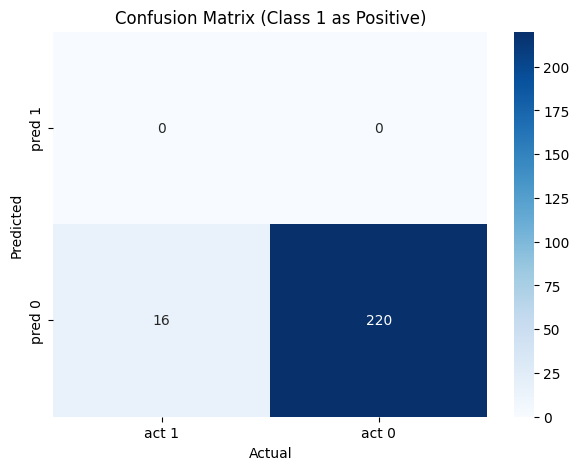

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
## 혼동행렬 및 classification_report 출력
print("기본 모델")
conf_matrix_basic = custom_confusion_matrix(y_test, y_pred_basic)
class_report_basic = classification_report(y_test, y_pred_basic, digits = 4, output_dict=True)
class_report_basic = pd.DataFrame(class_report_basic)

print("하이퍼파라미터 최적화 모델")
conf_matrix_best = custom_confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best,  digits = 4, output_dict=True)
class_report_best = pd.DataFrame(class_report_best)

In [25]:
class_report_basic

,0,1,accuracy,macro avg,weighted avg
precision,0.932203,0.0,0.932203,0.466102,0.869003
recall,1.000000,0.0,0.932203,0.500000,0.932203
f1-score,0.964912,0.0,0.932203,0.482456,0.899494
support,220.000000,16.0,0.932203,236.000000,236.000000


In [26]:
class_report_best

,0,1,accuracy,macro avg,weighted avg
precision,0.932203,0.0,0.932203,0.466102,0.869003
recall,1.000000,0.0,0.932203,0.500000,0.932203
f1-score,0.964912,0.0,0.932203,0.482456,0.899494
support,220.000000,16.0,0.932203,236.000000,236.000000


In [27]:
# EOS